In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, RepeatVector, TimeDistributed, SimpleRNN, Masking
from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, Lambda, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence, plot_model, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

from IPython.display import HTML

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from src.data import *
from src.utils import *
from src.models import *

# The Task

 As a well-known data scientist, you were asked for help by a company producing candies. Some of their products are plagued with different types of defects. The whole manufacture is equipped with sensors so there are several time series describing the process of producing candies. They would like to achieve two goals:


1. Have a predictive model which will tell them if a given candy has a defect and which ones

2. Perform a root cause analysis - they would like to know what patterns in the data are related to defects



Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

# Data Creation

- For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 
- One candy can have zero, one or more defects at once.
- Patterns are of different length
- There is one defect related to a pattern occurring at two sensors simultaneously



In [10]:
np.random.seed(42)

In [4]:
n = 50000

In [11]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)

[False False False False  True]


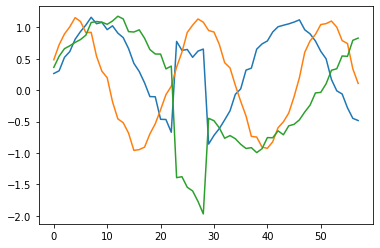

[False False False  True  True]


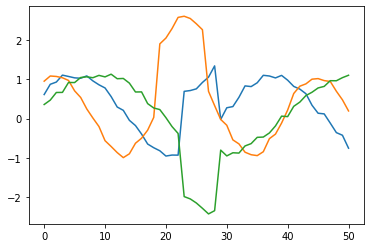

[False False False False False]


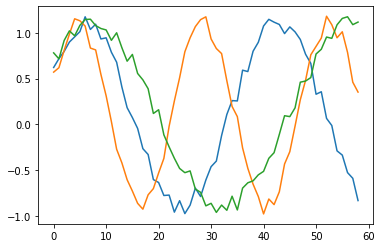

[ True False False False  True]


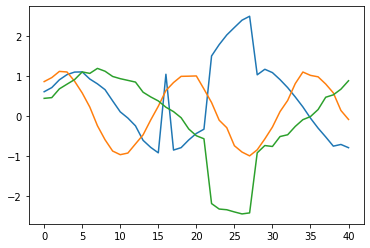

[False  True False False False]


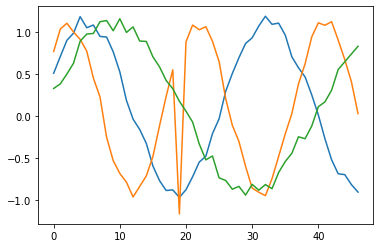

In [12]:
plot_sensors(xl,yl)

# Preprocess and split data

In [17]:
x_pad = pad_sequences(xl,dtype='float64',value=np.nan)
y = np.array(yl).astype(np.uint8)

In [18]:
samples, timesteps, features = x_pad.shape
x_pad.shape

(50000, 59, 3)

In [19]:
_, labels = y.shape
y.shape

(50000, 5)

In [20]:
scaler = MinMaxScaler()
x_pad = scaler.fit_transform(x_pad.reshape(-1, x_pad.shape[-1])).reshape(x_pad.shape)
X = np.nan_to_num(x_pad,nan=-2)

In [21]:
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

N = len(x_pad)
train_size,val_size,test_size = int(N*train_frac),int(N*val_frac),int(N*test_frac)
data_idx = list(range(N))
np.random.shuffle(data_idx)
train_idx,test_idx,val_idx = data_idx[:train_size],data_idx[-test_size:],data_idx[train_size+1:train_size+val_size]
X_train,y_train = X[train_idx],y[train_idx]
X_test,y_test = X[test_idx],y[test_idx]
X_val,y_val = X[val_idx],y[val_idx]

# The Model

In [24]:
?create_encoder

Signature: create_encoder(timesteps, features, labels, device='CPU')
Docstring: <no docstring>
File:      c:\users\lucas\desktop\studia\sem5\dl\candy-learning\src\models.py
Type:      function


In [26]:
model = create_encoder(timesteps,features,labels)
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 59, 3)             0         
                                                                 
 gru_2 (GRU)                 (None, 59, 32)            3552      
                                                                 
 gru_3 (GRU)                 (None, 8)                 1008      
                                                                 
 dense_3 (Dense)             (None, 128)               1152      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)  

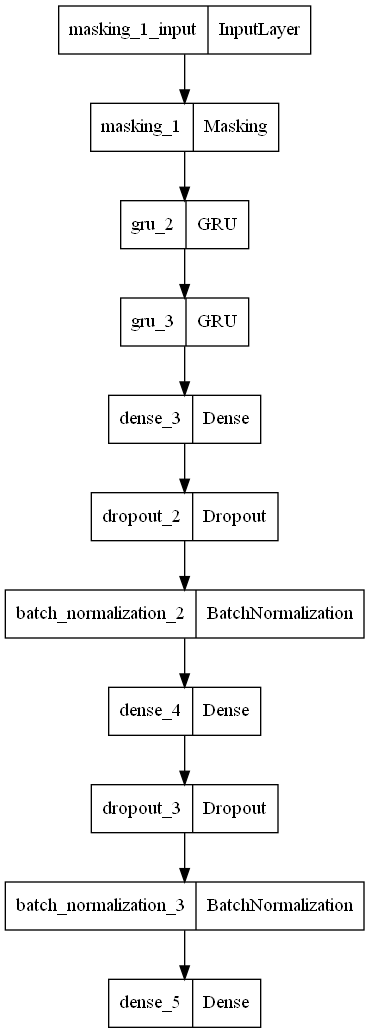

In [27]:
plot_model(model)

In [22]:
def learning_schedule(epoch,lr):
    return lr if epoch < 5 else lr * tf.math.exp(-0.1)

In [23]:
early = EarlyStopping(patience=3, restore_best_weights=True)
scheduler = LearningRateScheduler(learning_schedule)
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), batch_size=64, epochs=100, callbacks=[early])

Epoch 1/100
625/625 [==============================] - 20s 22ms/step - loss: 0.4271 - binary_accuracy: 0.8049 - val_loss: 0.4107 - val_binary_accuracy: 0.8033
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 0.3056 - binary_accuracy: 0.8678 - val_loss: 0.2651 - val_binary_accuracy: 0.8864
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 0.2416 - binary_accuracy: 0.9001 - val_loss: 0.3287 - val_binary_accuracy: 0.8597
Epoch 4/100
625/625 [==============================] - 13s 20ms/step - loss: 0.1574 - binary_accuracy: 0.9365 - val_loss: 0.1213 - val_binary_accuracy: 0.9476
Epoch 5/100
625/625 [==============================] - 12s 20ms/step - loss: 0.1357 - binary_accuracy: 0.9440 - val_loss: 0.1210 - val_binary_accuracy: 0.9474
Epoch 6/100
625/625 [==============================] - 12s 20ms/step - loss: 0.1331 - binary_accuracy: 0.9449 - val_loss: 0.1150 - val_binary_accuracy: 0.9492
Epoch 7/100
625/625 [=========================

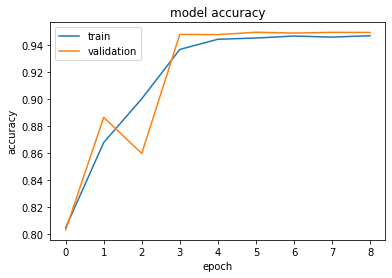

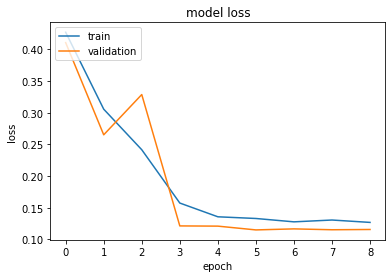

In [32]:
visualize(history)

In [33]:
y_pred = model.predict(X_test)

157/157 [==============================] - 1s 6ms/step


In [34]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 1s 7ms/step - loss: 0.1142 - binary_accuracy: 0.9496


[0.11421503871679306, 0.9496400356292725]

In [35]:
y_pred

array([[5.3707281e-05, 1.0000000e+00, 1.8418765e-01, 1.2385958e-14,
        9.6629788e-05],
       [1.0000000e+00, 1.0000000e+00, 1.5812407e-01, 8.9702407e-15,
        5.7815443e-05],
       [1.0000000e+00, 5.9204835e-06, 2.2369893e-01, 3.1733175e-11,
        3.9417262e-04],
       ...,
       [7.3021920e-06, 9.0116573e-06, 2.3657486e-01, 6.1138254e-11,
        6.8426583e-05],
       [1.0000000e+00, 7.5781804e-06, 2.2445859e-01, 9.2435859e-12,
        3.2501851e-04],
       [1.7118802e-04, 5.6126115e-05, 2.8310868e-01, 3.0941946e-12,
        1.0000000e+00]], dtype=float32)

In [36]:
y_test

array([[0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]], dtype=uint8)

# Reversed network